# Connect Intensive - Machine Learning Nanodegree

## Week 7. PCA Miniproject

### Objectives    

  - Perform Principal Component Analysis (PCA) on a large set of features to explain as much of the variance as possible in the data using a smaller set of features.
  - Recognize differences between `train_test_split()` and `StratifiedShuffleSplit()` when creating training and testing sets.
  - Introduce the `class_weight` parameter for `SVC()`, to see how correctly predicting targets from a smaller class size can be weighted more heavily.
  - Visualize the eigenfaces (orthonormal basis of components) that result from PCA.
  
### Prerequisites
  - [matplotlib](http://matplotlib.org/index.html)  
  - [numpy](http://www.scipy.org/scipylib/download.html)  
  - [pandas](http://pandas.pydata.org/getpandas.html)  
  - [sklearn](http://scikit-learn.org/stable/install.html)  
  

  > This notebook builds upon [`pca/eigenfaces.py`](https://github.com/udacity/ud120-projects/blob/master/pca/eigenfaces.py) from [**Udacity ud120-projects repo**](https://github.com/udacity/ud120-projects). It derives from [an eigenfaces/SVM example in the sklearn documentation](http://scikit-learn.org/0.18/auto_examples/applications/face_recognition.html).

## 1 | Get the Data

The dataset for this mini-project comes from ["Labeled Faces in the Wild" (LFW)](http://vis-www.cs.umass.edu/lfw/), a database of more than 13,000 face photographs designed for studying the problem of unconstrained face recognition. We are going to use the **funneled** dataset, which comes from the following paper:

> Gary B. Huang, Vidit Jain, and Erik Learned-Miller. [**Unsupervised Joint Alignment of Complex Images**](http://vis-www.cs.umass.edu/papers/iccv07alignment.pdf). *International Conference on Computer Vision (ICCV), 2007.*

Section 2 of the paper describes the preprocessing steps of [congealing](http://vis-www.cs.umass.edu/congeal.html) and funneling to align images in the dataset.

The original source of this PCA demo comes from the [scikit-learn documentation](http://scikit-learn.org/0.18/auto_examples/applications/face_recognition.html).

In [1]:
import numpy as np
from time import time
import logging
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
# useful to monitor progress while downloading LFW data
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

**Run** the cell below to download the data using [the `sklearn` function `fetch_lfw_people()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html). The data is ~200MB, so the download may take a while. The data will be loaded into the dictionary `lfw_people`. The dictionary contains several items:
  - `lfw_people.DESCR`: string -- a short description of the data dictionary.
  - `lfw_people.data`: 2-D numpy array (`dtype=float32`) with shape `(n_samples, n_features)`
    - Each entry in the array is a value ranging from 0.0 to 255.0, denoting the 8-bit [grayscale](https://en.wikipedia.org/wiki/Grayscale) value of each pixel.
    - `n_samples`: the total number of images, the instances/inputs in the dataset.
    - `n_features`: the number of pixels per image, the features of the dataset.
  - `lfw_people.images`: 3-D numpy array (`dtype=float32`) with shape `(n_samples, height, width)`.
    - `images` is just `data` reshaped, so that `height` $\times$ `width` = `n_features`
  - `lfw_people.target`: 1-D numpy array (`dtype=int64`) of length `n_samples`, the labels of each image
  - `lfw_people.target_names`: 1-D numpy array of length `n_classes`
  
>**Note:** Sometimes [the pillow module](https://python-pillow.org/) (which is being used in this example) can cause trouble with this notebook. If you get an error related to the `fetch_lfw_people()` command, try the following:

>``pip install --upgrade PILLOW``

In [2]:
# Download the data, if not already on disk, and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# Or you can use the pickled file included in the folder with this notebook
'''import pickle
with open('lfw_people.pickle', 'rb') as handle:
    lfw_people2 = pickle.load(handle)'''

"import pickle\nwith open('lfw_people.pickle', 'rb') as handle:\n    lfw_people2 = pickle.load(handle)"

>**Note:** In the call to `fetch_lfw_people()`, the parameter `min_faces_per_person` is set to 70. This ensures that the extracted dataset will only retain pictures of people that have at least 70 different pictures. The `resize` parameter of 0.4 scales each image to 40% of its original size, so that the dataset takes up less memory.

In [4]:
# Print the indices and names of the people in the lfw_people dataset
for idx, name in enumerate(lfw_people.target_names):
    print "{}: {}".format(idx, name)

0: Ariel Sharon
1: Colin Powell
2: Donald Rumsfeld
3: George W Bush
4: Gerhard Schroeder
5: Hugo Chavez
6: Tony Blair


**Run** the cell below to extract the shape information (number of samples, number of features, image height and width) from `lfw_people.images` and `lfw_people.data`. You will see a summary of the dataset: the numbers of samples (images), features (pixels), and classes (targets). You will also see the number of images per target in the dataset.

In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2-D data directly
# relative pixel positions info will be ignored by this model
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the target ID of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# print a summary of the total dataset size
print 'Total dataset size:'
print '  n_samples  : {:>4}'.format(n_samples)
print '  n_features : {:>4}'.format(n_features)
print '  n_classes  : {:>4}\n'.format(n_classes)

# print the number of images for each target in the dataset
print 'Images per Target:'
for idx, name in enumerate(lfw_people.target_names):
    print '  {:<18}: {:>3} images'.format(name, np.sum(lfw_people.target == idx))

Total dataset size:
  n_samples  : 1288
  n_features : 1850
  n_classes  :    7

Images per Target:
  Ariel Sharon      :  77 images
  Colin Powell      : 236 images
  Donald Rumsfeld   : 121 images
  George W Bush     : 530 images
  Gerhard Schroeder : 109 images
  Hugo Chavez       :  71 images
  Tony Blair        : 144 images


## 2 | Split the Data

**Run** the cells below to split the data into training and test (validation) sets using [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). As a comparison, we also split the data using `StratifiedShuffleSplit()` and check the percentages of each target in the dataset.

In [6]:
# Split into a training and testing set using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Summarize the proportions of each label in the training and testing sets
print 'train_test_split() results:'
print '{:>28}{:>8}'.format('train', 'test')
for idx, name in enumerate(lfw_people.target_names):
    print '  {:<18}: {:6.1f}% {:6.1f}%'.format(name,\
                  np.sum(y_train == idx) * 100.0 / len(y_train),\
                  np.sum(y_test == idx) * 100.0 / len(y_test))

train_test_split() results:
                       train    test
  Ariel Sharon      :    6.4%    4.3%
  Colin Powell      :   18.3%   18.2%
  Donald Rumsfeld   :    9.6%    8.5%
  George W Bush     :   39.9%   46.1%
  Gerhard Schroeder :    8.7%    7.4%
  Hugo Chavez       :    5.6%    5.0%
  Tony Blair        :   11.4%   10.5%


In [7]:
# Compare with StratifiedShuffleSplit()
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train_s, X_test_s = X[train_index], X[test_index]
    y_train_s, y_test_s = y[train_index], y[test_index]

# Summarize the proportions of each label in the training and testing sets
print '\nStratifiedShuffleSplit() comparison:'
print '{:>28}{:>8}'.format('train', 'test')
for idx, name in enumerate(lfw_people.target_names):
    print '  {:<18}: {:6.1f}% {:6.1f}%'.format(name,\
                  np.sum(y_train_s == idx) * 100.0 / len(y_train_s),\
                  np.sum(y_test_s == idx) * 100.0 / len(y_test_s))


StratifiedShuffleSplit() comparison:
                       train    test
  Ariel Sharon      :    5.9%    6.2%
  Colin Powell      :   18.3%   18.2%
  Donald Rumsfeld   :    9.4%    9.3%
  George W Bush     :   41.2%   41.1%
  Gerhard Schroeder :    8.4%    8.5%
  Hugo Chavez       :    5.5%    5.4%
  Tony Blair        :   11.2%   11.2%


#### QUESTION: 
What is the difference between `train_test_split()` and `StratifiedShuffleSplit()`?

## 3 | Principal Component Analysis

The goal of [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is to describe the maximal amount of variance in a dataset by the fewest number of composite features. 

**Run** the cell below to perform [Principal Component Analysis with `sklearn`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on the training set of images to find the *eigenfaces*, or the orthonormal basis resulting from PCA.

>**Note:** There's a little background on [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) and [Randomized SVD](https://research.facebook.com/blog/fast-randomized-svd/) that may be useful or interesting to read here... but it's not necessary to fully understand SVD to appreciate the results of PCA.

In [8]:
# Compute a PCA (eigenfaces) on the face dataset

# number of components
n_components = 150

# perform PCA on the training set
print 'Extracting the top {} eigenfaces from {} faces'.format(n_components, X_train.shape[0])
t0 = time() # track time
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print 'done in {:0.3f}s'.format(time() - t0)

# Reshape the PCA components based on the image dimensions
eigenfaces = pca.components_.reshape((n_components, h, w))

# Project input data 
print 'Projecting the input data on the eigenfaces orthonormal basis'
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print 'done in {:0.3f}s'.format(time() - t0)

Extracting the top 150 eigenfaces from 1030 faces
done in 0.121s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s


Now that we've conducted PCA on the training set, we can see how much of the variance in the dataset is explained by each eigenface (or each component of the orthonormal basis). The components are ordered by ratio of explained variance in descending order, and after conducting PCA this information is stored in the attribute `pca.explained_variance_ratio_`. **Run** the cell below to print the explained variance percentage from the first five eigenfaces, and the total explained variance percentage of all 150 eigenfaces.

In [9]:
# print the explained variance
for idx, var in enumerate(pca.explained_variance_ratio_[:5]):
    print 'Eigenface {} explains {:5.2f}% of the variance.'.format(idx+1, var*100.0)
    
print '\nIn total, the first {} eigenfaces explain {:5.2f}% of the variance.'\
      .format(len(pca.explained_variance_ratio_),\
              100.0*np.sum(pca.explained_variance_ratio_))

Eigenface 1 explains 18.17% of the variance.
Eigenface 2 explains 14.33% of the variance.
Eigenface 3 explains  6.79% of the variance.
Eigenface 4 explains  5.90% of the variance.
Eigenface 5 explains  4.52% of the variance.

In total, the first 150 eigenfaces explain 93.29% of the variance.


The first 150 components account for over 90% of the variance!. This leads us to believe that using these 150 components, we would recover most of the essential characteristics of the data. We can also plot the cumulative explained variance as a function of n_components. **Run** the cell below to find out.  

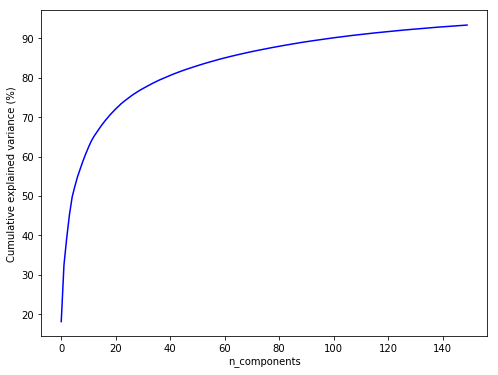

In [10]:
# plot cumulative explained variance as a function of n_components
plt.figure(figsize=(8, 6))
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100) # Cumulative Variance explains
plt.plot(var1, color='b')
plt.xlabel('n_components')
plt.ylabel('Cumulative explained variance (%)')

Now let's train a Support Vector Machine classifier. As we can see, the dataset has class imbalance problem. One way of dealing with class imbalance is to adjust the `class_weight` parameter in `SVC()`, so that the model score improves by different amounts depending on the class of the that targets are accurately classified. For a more detailed explanation of the `class_weight` parameter, you can read the [`SVC()` documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), or check out this [stackoverflow post](http://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work).

In [11]:
weights = n_samples*1.0 / (n_classes * np.bincount(y_train))
print '{:<23}{:<8}{:<6}'.format('Target Name', 'Weight', 'Count')
for idx, name in enumerate(lfw_people.target_names):
    print '  {:<18}: {:6.2f} {:>6}'.format(name, weights[idx], np.sum(y_train == idx))

Target Name            Weight  Count 
  Ariel Sharon      :   2.79     66
  Colin Powell      :   0.97    189
  Donald Rumsfeld   :   1.86     99
  George W Bush     :   0.45    411
  Gerhard Schroeder :   2.04     90
  Hugo Chavez       :   3.17     58
  Tony Blair        :   1.57    117


As you can see from the above, rarer classes or targets are weighted more heavily, i.e., it's more important for the classifier to get those targets correct. Now that we understand how the `class_weight` parameter adds weight to the rarer classes, we can use [`GridSearchCV()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal parameters for a SVM classifier. Here, we're using the radial basis function (RBF) kernel, and we're tuning the parameters `C` ("hard-margin" SVM when `C` is large vs. "soft-margin" SVM when `C` is small) and `gamma` (data points have a long-ranged influence when `gamma` is small, or a short-ranged influence when `gamma` is large). 

**Run** the cell below to find the optimal values for the `C` and `gamma` parameters in the `SVC()` classifier,  using the eigenfaces (`X_train_pca`) as the features.

In [12]:
# Train a SVM classification model
print 'Fitting the classifier to the training set'
t0 = time()
param_grid = {'C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 5e3, 1e4],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

# Display the detailed results of the grid search + cross-validation:
print 'done in {:0.3f}s'.format(time() - t0)
print 'Best parameters set found on development set:\n'
print clf.best_params_
print '\nGrid scores:\n'
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print '%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params)

Fitting the classifier to the training set
done in 41.023s
Best parameters set found on development set:

{'C': 10.0, 'gamma': 0.001}

Grid scores:

0.083 (+/-0.036) for {'C': 0.01, 'gamma': 0.0001}
0.083 (+/-0.036) for {'C': 0.01, 'gamma': 0.001}
0.083 (+/-0.036) for {'C': 0.01, 'gamma': 0.01}
0.083 (+/-0.036) for {'C': 0.01, 'gamma': 0.1}
0.083 (+/-0.036) for {'C': 0.01, 'gamma': 1}
0.083 (+/-0.036) for {'C': 0.01, 'gamma': 10}
0.083 (+/-0.036) for {'C': 0.01, 'gamma': 100}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 0.0001}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 0.001}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 0.01}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 0.1}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 1}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 10}
0.083 (+/-0.036) for {'C': 0.1, 'gamma': 100}
0.125 (+/-0.082) for {'C': 1, 'gamma': 0.0001}
0.792 (+/-0.045) for {'C': 1, 'gamma': 0.001}
0.669 (+/-0.042) for {'C': 1, 'gamma': 0.01}
0.399 (+/-0.001) for {'C': 1, 'gamma': 0.1}
0.399 (+/-0.

**Run** the cell below to make predictions on the test data and use a classification report and a confusion matrix to summarize the classifier performance. 

>**Note:** We trained the classifier using the *projections* of the training set features onto the *eigenfaces* (the orthonormal basis of transformed coordinates), so we must also make predictions using the projections of the test set features onto eigenfaces.

In [13]:
print 'Predicting the people names on the testing set'
t0 = time()
y_pred = clf.predict(X_test_pca)
print 'done in {:0.3f}s'.format(time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.034s
                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.64      0.67        11
     Colin Powell       0.74      0.89      0.81        47
  Donald Rumsfeld       0.78      0.82      0.80        22
    George W Bush       0.95      0.86      0.90       119
Gerhard Schroeder       0.74      0.89      0.81        19
      Hugo Chavez       0.90      0.69      0.78        13
       Tony Blair       0.79      0.81      0.80        27

      avg / total       0.85      0.84      0.84       258

[[  7   1   2   1   0   0   0]
 [  1  42   1   3   0   0   0]
 [  1   1  18   0   0   0   2]
 [  1   9   2 102   2   1   2]
 [  0   1   0   0  17   0   1]
 [  0   2   0   0   1   9   1]
 [  0   1   0   1   3   0  22]]


Now we can make a qualitative evaluation of the predictions using matplotlib. **Run** the cell below to define `plot_gallery()` and `title()` helper functions, and then visualize the first few faces from the test set, labeled with the predicted and actual classes. How did our optimal classifier do on these faces?

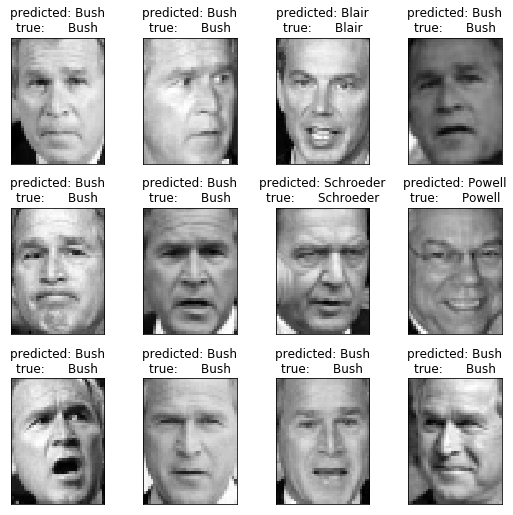

In [14]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

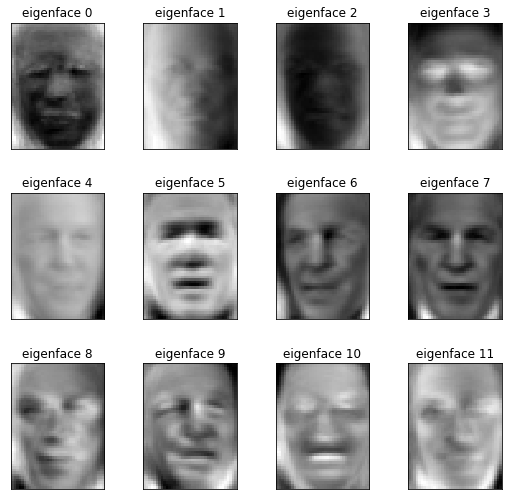

In [15]:
# plot the gallery of the most significative eigenfaces
eigenface_titles = ['eigenface %d' % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips. 

#### QUESTIONS

**Q1:** Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. If you see a higher F1 score, does it mean the classifier is doing better, or worse?

In [16]:
from sklearn.metrics import f1_score
N = [10, 15, 25, 50, 100, 250]
for n in N:
    pca = PCA(n_components=n, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    clf = SVC(kernel='rbf', class_weight='balanced', C=10.0, gamma=0.001)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    print classification_report(y_test, y_pred, target_names=target_names)

                   precision    recall  f1-score   support

     Ariel Sharon       0.15      0.45      0.23        11
     Colin Powell       0.42      0.30      0.35        47
  Donald Rumsfeld       0.26      0.41      0.32        22
    George W Bush       0.81      0.29      0.43       119
Gerhard Schroeder       0.11      0.21      0.14        19
      Hugo Chavez       0.15      0.54      0.23        13
       Tony Blair       0.32      0.37      0.34        27

      avg / total       0.53      0.33      0.36       258

                   precision    recall  f1-score   support

     Ariel Sharon       0.16      0.45      0.24        11
     Colin Powell       0.61      0.57      0.59        47
  Donald Rumsfeld       0.44      0.68      0.54        22
    George W Bush       0.91      0.54      0.68       119
Gerhard Schroeder       0.34      0.53      0.42        19
      Hugo Chavez       0.44      0.54      0.48        13
       Tony Blair       0.50      0.63      0.56    

**Q2:** Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?

In [17]:
N2 = [250, 400, 600]
for n in N2:
    pca = PCA(n_components=n, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    clf = SVC(kernel='rbf', class_weight='balanced', C=10.0, gamma=0.001)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    print classification_report(y_test, y_pred, target_names=target_names)

                   precision    recall  f1-score   support

     Ariel Sharon       0.73      0.73      0.73        11
     Colin Powell       0.77      0.85      0.81        47
  Donald Rumsfeld       0.74      0.77      0.76        22
    George W Bush       0.91      0.90      0.90       119
Gerhard Schroeder       0.78      0.74      0.76        19
      Hugo Chavez       0.75      0.46      0.57        13
       Tony Blair       0.82      0.85      0.84        27

      avg / total       0.83      0.83      0.83       258

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.55      0.67        11
     Colin Powell       0.69      0.89      0.78        47
  Donald Rumsfeld       0.79      0.68      0.73        22
    George W Bush       0.90      0.94      0.92       119
Gerhard Schroeder       0.93      0.68      0.79        19
      Hugo Chavez       0.88      0.54      0.67        13
       Tony Blair       0.79      0.70      0.75    